In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import scipy
from scipy import sparse
import os
import scipy.stats as stats

from matplotlib import rcParams
from tqdm import tqdm

from scipy.stats import pearsonr


import warnings
warnings.filterwarnings("ignore")

In [22]:
r848_v1_path = 'insert data pathway here'
r848_v2_path = 'insert data pathway here'

ntc_v1_path = 'insert data pathway here'
ntc_v2_path = 'insert data pathway here'

lps_v1_path = 'insert data pathway here'
lps_v2_path = 'insert data pathway here'

# Extended Figure 2c)

In [3]:
r848_v1 = sc.read(r848_v1_path)
r848_v2 = sc.read(r848_v2_path)

sc.pp.normalize_total(r848_v1, target_sum = 1e4)
sc.pp.normalize_total(r848_v2, target_sum = 1e4)

pdc_v1 = r848_v1[r848_v1.obs.CellType == 'pDC'].to_df()
pdc_v2 = r848_v2[r848_v2.obs.CellType == 'pDC'].to_df()


In [4]:
v1_scat = pd.DataFrame({'IRF7':pdc_v1['IRF7'], 'SOCS1':pdc_v1['SOCS1'], 'V': 'V1'})
v2_scat = pd.DataFrame({'IRF7':pdc_v2['IRF7'], 'SOCS1':pdc_v2['SOCS1'], 'V': 'V2'})

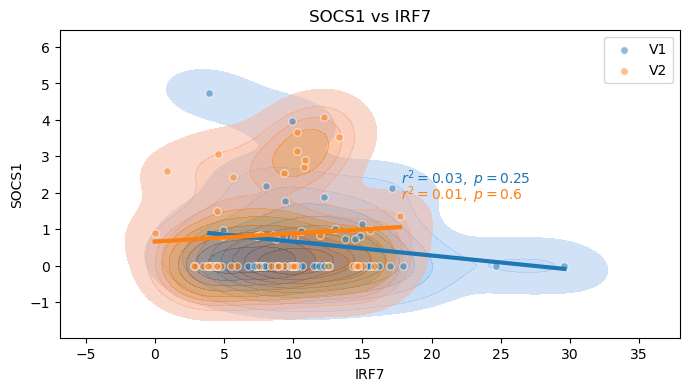

In [6]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
genex = 'IRF7'
geney = 'SOCS1'
sns.kdeplot(x=genex, y=geney, data=v1_scat, fill=True, alpha = 0.5)
sns.kdeplot(x=genex, y=geney, data=v2_scat, fill=True, alpha = 0.5)
sns.regplot(x=genex, y=geney, data=v1_scat, fit_reg=True, ci=None, label='V1', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
sns.regplot(x=genex, y=geney, data=v2_scat, fit_reg=True, ci=None, label='V2', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
slope, intercept, r_value_v1, p_value_v1, std_err = scipy.stats.linregress(v1_scat[genex], v1_scat[geney])
slope, intercept, r_value_v2, p_value_v2, std_err = scipy.stats.linregress(v2_scat[genex], v2_scat[geney])
text1 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v1 ** 2, p_value_v1)
text2 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v2 ** 2, p_value_v2)
plt.text(0.55, .5, text1, transform=ax.transAxes, color = sns.color_palette()[0])
plt.text(0.55, .45, text2, transform=ax.transAxes, color = sns.color_palette()[1])

plt.title('SOCS1 vs ' + genex)
plt.legend()


# Extended Figure 3c)

In [7]:
nano_ad = sc.read('../Nanostring_data/two_cartridge_normalized_data_filteredForFigure.h5ad')
sc.pp.log1p(nano_ad)

In [8]:
#hallmark_ifna2 = 'ADAR,B2M,BATF2,BST2,C1S,CASP1,CASP8,CCRL2,CD47,CD74,CMPK2,CNP,CSF1,CXCL10,CXCL11,DDX60,DHX58,EIF2AK2,ELF1,EPSTI1,MVB12A,TENT5A,CMTR1,GBP2,GBP4,GMPR,HERC6,HLA-C,IFI27,IFI30,IFI35,IFI44,IFI44L,IFIH1,IFIT2,IFIT3,IFITM1,IFITM2,IFITM3,IL15,IL4R,IL7,IRF1,IRF2,IRF7,IRF9,ISG15,ISG20,LAMP3,LAP3,LGALS3BP,LPAR6,LY6E,MOV10,MX1,NCOA7,NMI,NUB1,OAS1,OASL,OGFR,PARP12,PARP14,PARP9,PLSCR1,PNPT1,HELZ2,PROCR,PSMA3,PSMB8,PSMB9,PSME1,PSME2,RIPK2,RNF31,RSAD2,RTP4,SAMD9,SAMD9L,SELL,SLC25A28,SP110,STAT2,TAP1,TDRD7,TMEM140,TRAFD1,TRIM14,TRIM21,TRIM25,TRIM26,TRIM5,TXNIP,UBA7,UBE2L6,USP18'.split(',')
hallmark_ifna2 = [
    "B2M", "BST2", "CASP1", "CCRL2", "CD74", "CSF1", "CXCL10", 
    "CXCL11", "HLA-C", "IFI35", "IFIH1", "IFIT2", "IFITM1", 
    "IL15", "IL4R", "IRF1", "IRF7", "MX1", "PSMB8", "PSMB9", "SELL", 
    "STAT2", "TAP1"
]




Text(0, 0.5, 'PC3 (19.0%)')

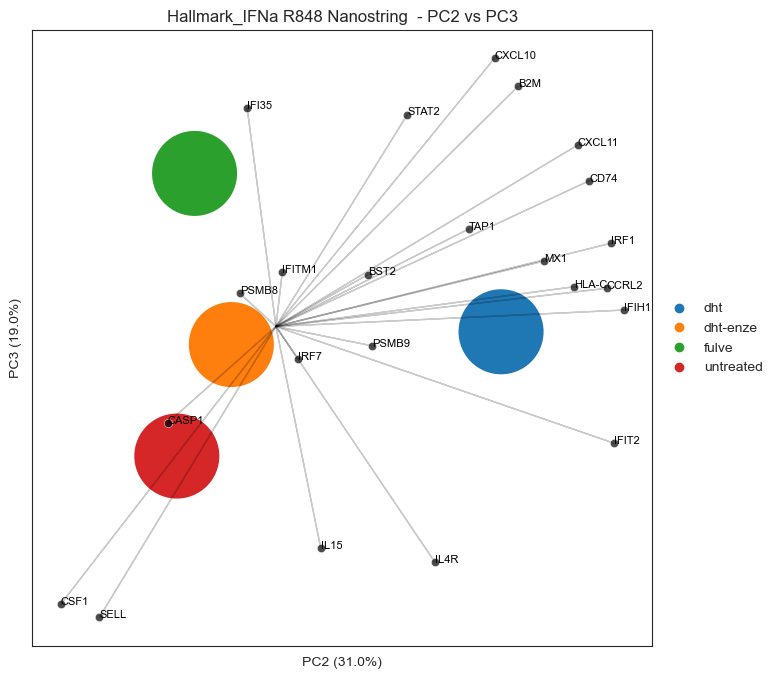

In [9]:
stim = 'R848'
nano_ad_stim = nano_ad[nano_ad.obs.stim == stim.lower()].copy()
sc.pp.scale(nano_ad_stim, max_value=10)
sc.tl.pca(nano_ad_stim, svd_solver='arpack')

df_loadings = pd.DataFrame(nano_ad_stim.varm['PCs'], columns = ['PC1', 'PC2', 'PC3'], index=nano_ad.var_names)
df_loadings['hallmark'] = 'X'
df_loadings.loc[df_loadings.index.isin(hallmark_ifna2), 'hallmark'] = 'HallmarkIFNa2'

df_loadings = df_loadings[df_loadings.hallmark != 'X']

V1 = sc.read_h5ad(lps_v1_path)
V2 = sc.read_h5ad(lps_v2_path)

sc.pp.normalize_total(V1, target_sum=1e4)
sc.pp.normalize_total(V2, target_sum=1e4)

df1 = V1.to_df()
df2 = V2.to_df()

nano_ad_stim.obs.treatment = nano_ad_stim.obs.treatment.astype("category")
sc.pl.pca(nano_ad_stim, color=['treatment'],components=['1,2'], ax = ax, show = False, size = 15000)

scale_factor = 50.5

sns.set_style('ticks')

pc_1 = ['PC1']
pc_2 = ['PC2']
pc_3 = ['PC3']
    

scalePC1 = 1.0/(df_loadings[pc_1].max() - df_loadings[pc_1].min()).values[0]
scalePC2 = 1.0/(df_loadings[pc_2].max() - df_loadings[pc_2].min()).values[0]
scalePC3 = 1.0/(df_loadings[pc_3].max() - df_loadings[pc_3].min()).values[0]

df_loadings_filt = df_loadings[df_loadings.index.isin(hallmark_ifna2)].copy()
#df_loadings_filt['PC1'] = df_loadings_filt['PC1']*scalePC1*scale_factor
#df_loadings_filt['PC2'] = df_loadings_filt['PC2']*scalePC2*scale_factor
#df_loadings_filt['PC3'] = df_loadings_filt['PC3']*scalePC3*scale_factor
df_loadings_filt[pc_1] = df_loadings_filt[pc_1]*scalePC1*scale_factor
df_loadings_filt[pc_2] = df_loadings_filt[pc_2]*scalePC2*scale_factor
df_loadings_filt[pc_3] = df_loadings_filt[pc_3]*scalePC3*scale_factor

fig, ax = plt.subplots(figsize = (8,8))

sc.pl.pca(nano_ad_stim, color=['treatment'],components=['2,3'], ax = ax, show = False, size = 15000)

for i, feature in enumerate(df_loadings_filt.index):
    ax.arrow(0, 0, np.float(df_loadings.loc[feature, pc_2]*scalePC2*scale_factor), 
             np.float(df_loadings.loc[feature, pc_3]*scalePC3*scale_factor), width = 0.004, color = 'black', alpha = 0.2)
    
    ax.text(df_loadings_filt.loc[feature, pc_2],
            df_loadings_filt.loc[feature, pc_3],
            feature, fontsize=8, color = "black")#color)
        
        
sns.scatterplot(data = df_loadings_filt, x = 'PC2', y = 'PC3',
                   legend = False, ax = ax, color = "black", alpha = 0.7)#[1], label = 'V1 higher')

ax.set_title('Hallmark_IFNa R848 Nanostring  - PC2 vs PC3')
ax.set_xlabel('PC2 (%s'%(np.round(np.round(nano_ad_stim.uns['pca']['variance_ratio'][1],2)*100, 2)) + '%)')
ax.set_ylabel('PC3 (%s'%(np.round(np.round(nano_ad_stim.uns['pca']['variance_ratio'][2],2)*100, 2)) + '%)')
#plt.savefig('figures_temp_delete/nanostring_r848_ifna_pc2vspv3.pdf', dpi = 200, bbox_inches = 'tight')

# Extended Figure 4e-h

## Violinplots of Th1, Th2 and Th17 markers

In [10]:
ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)

In [11]:
th1_markers = ['TNF', 'IFNG', 'EGR2', 'CCL4L2', 'F2R', 'APOBEC3G', 'FASLG', 'IL2',  'CCL4', 'CCL5', 'AOAH', 'GZMA', 'GZMB', 'TBX21', 'GZMK', 'ALDOC']

th2_markers = [ 'PLIN2', 'CD83', 'NFKBIZ', 'NFKBID', 'CCR4', 'GATA3', 'PPARG', 'LIF', 'IL9R', 'BCAR3', 'C1orf162', 'CHDH', 'GPR35', 'NENF', 'PDLIM5', 'PLN']

th17_markers = [ 'ABCB1', 'THBS1', 'TRBV18', 'TRAV13-2', 'PTPN22', 'RUNX2', 'IL18RAP', 'IL23R', 'GPR65', 'MGAT4A', 'TMIGD2']



In [12]:
set(ntc_v2.obs.CellType_sub)

{'B',
 'CD4T',
 'CD8T',
 'DC',
 'Megakaryocyte',
 'Memory CD4T',
 'Memory CD8T',
 'Monocyte',
 'NK',
 'Naive CD4T',
 'Naive CD8T',
 'gDT',
 'pDC'}

In [13]:
cd4t_v1 = ntc_v1[ntc_v1.obs.CellType_sub == 'Memory CD4T'].to_df()
cd4t_v2 = ntc_v2[ntc_v2.obs.CellType_sub == 'Memory CD4T'].to_df()

In [14]:
markers = th1_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th1_df = pd.concat([v1,v2])

markers = th2_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th2_df = pd.concat([v1,v2])

markers = th17_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th17_df = pd.concat([v1,v2])



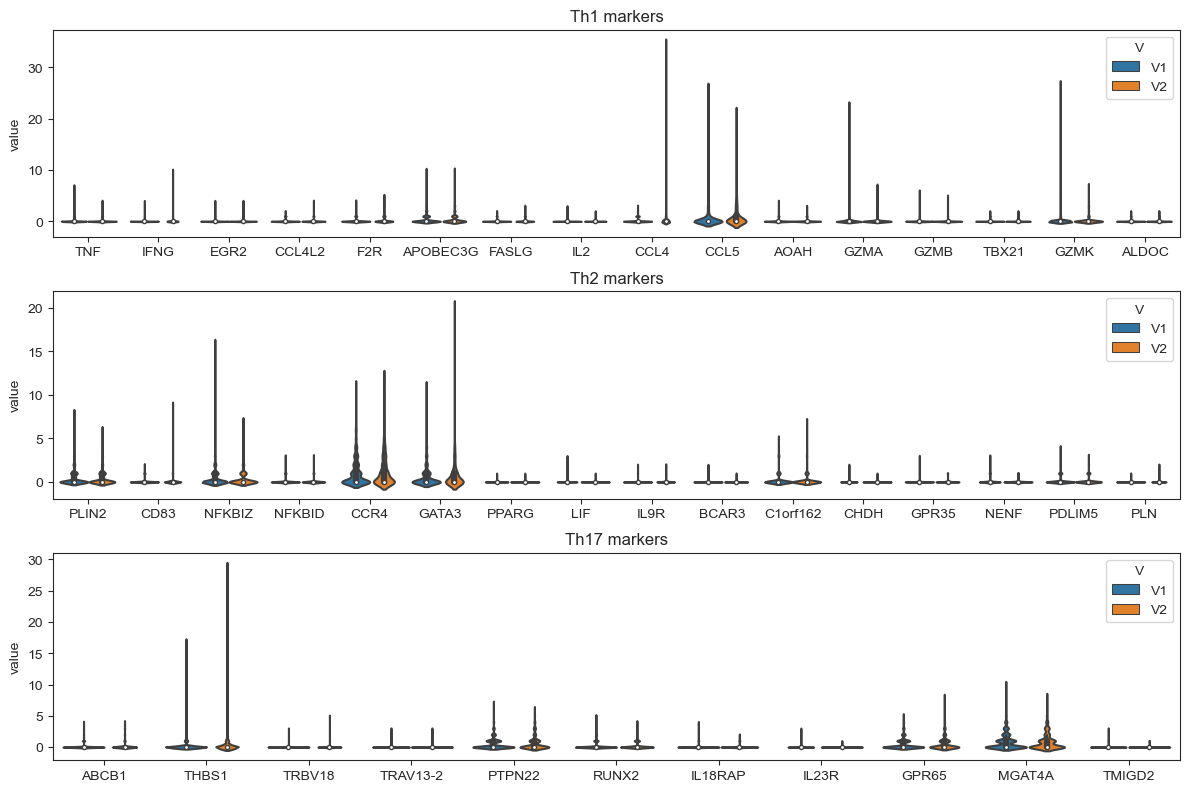

In [16]:
fig, ax = plt.subplots(3,1, figsize = (12,8))
sns.violinplot(data = th1_df, x = 'variable', y = 'value', hue = 'V', ax = ax[0])
sns.violinplot(data = th2_df, x = 'variable', y = 'value', hue = 'V', ax = ax[1])
sns.violinplot(data = th17_df, x = 'variable', y = 'value', hue = 'V', ax = ax[2])

plt.tight_layout()
ax[0].set_title('Th1 markers')
ax[1].set_title('Th2 markers')
ax[2].set_title('Th17 markers')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

#plt.savefig('Th1_Th2_Th17_markers_memoryCD4TNTC.pdf', bbox_inches = 'tight', dpi = 200)

## Exhaustion markers CD8T

In [28]:
ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)

sc.pp.normalize_total(ntc_v1, target_sum=1e4)
sc.pp.normalize_total(ntc_v2, target_sum=1e4)

ct = 'CD8T'
unstim_V1 = ntc_v1[ntc_v1.obs.CellType == ct].to_df() 
unstim_V2 = ntc_v2[ntc_v2.obs.CellType == ct].to_df()

#stim_v1 = lps_v1[lps_v1.obs.CellType.isin(['CD8T','CD4T'])].to_df() 
#stim_v1 = lps_v2[lps_v2.obs.CellType.isin(['CD8T','CD4T'])].to_df() 

unstim_V1 = unstim_V1.groupby(axis=1, level=0).sum()
unstim_V2 = unstim_V2.groupby(axis=1, level=0).sum()

unstim_V1 = unstim_V1[unstim_V1.columns[unstim_V1.columns.isin(unstim_V2.columns)]]
unstim_V2 = unstim_V2[unstim_V2.columns[unstim_V2.columns.isin(unstim_V1.columns)]]

exh_markers = ['PDCD1', 'LAG3', 'CD160', 'TIGIT', 'HAVCR2', 'CTLA4', 'ENTPD1', 'ITGAE', 'TNFRSF9', 'TNFRSF18']


In [29]:
scipy.stats.ttest_ind(np.log1p(np.sum(unstim_V1[exh_markers], axis = 1)), np.log1p(np.sum(unstim_V2[exh_markers], axis = 1)))

Ttest_indResult(statistic=-3.8574553936574283, pvalue=0.00011540739074584107)

Text(0.5, 1.0, 'Exhaustion markers CD8T ntc - sum \n Genes: PDCD1, LAG3, CD160, TIGIT, HAVCR2, CTLA4, ENTPD1, ITGAE, TNFRSF9, TNFRSF18')

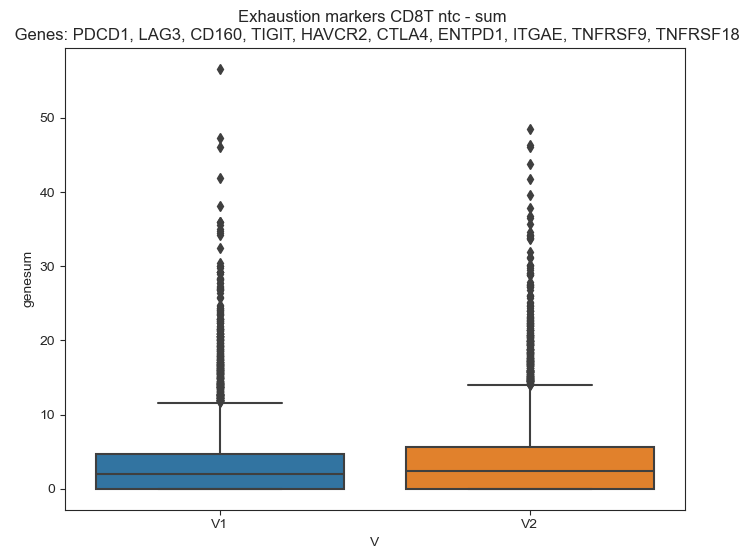

In [30]:
sum_df1 = np.sum(unstim_V1[exh_markers], axis = 1)
sum_df2 = np.sum(unstim_V2[exh_markers], axis = 1)

df1 = pd.DataFrame(sum_df1)
df1.columns = ['genesum']
df1['V'] = 'V1'
df2 = pd.DataFrame(sum_df2)
df2.columns = ['genesum']
df2['V'] = 'V2'
sumdf = pd.concat([df1, df2])

sumdf['gene'] = 'Exhaustion_markers'

plt.figure(figsize=(8, 6))
sns.boxplot(data = sumdf, x = 'V', y = 'genesum')
plt.title('Exhaustion markers CD8T ntc - sum \n Genes: ' + ', '.join(exh_markers))
#plt.savefig('exhaustionmarkers_sum_ntcCD8T_noTIGITorTNFRSF18.svg', bbox_inches = 'tight', dpi = 200)

# Extended Figure 5b)

In [2]:
hpa = pd.read_csv('/Users/rikardforlin/Forskning/jupyter_scripts/human_prot_atlas_immune_cell_sample.tsv', sep = '\t')

In [3]:
hpa_filt = hpa[hpa['Immune cell'].isin(['NK-cell', 'classical monocyte', 'memory B-cell', 'memory CD4 T-cell', 'memory CD8 T-cell', 'myeloid DC',
 'naive B-cell',
 'naive CD4 T-cell',
 'naive CD8 T-cell',
 'T-reg',
 'intermediate monocyte',
 'non-classical monocyte',
 'plasmacytoid DC'])]


In [4]:
hpa_filt = hpa_filt[hpa_filt['Gene name'].isin(['ESR1', 'ESR2', 'AR'])]


In [5]:
ct_dic = {'NK-cell':'NK', 'T-reg':'CD4T', 'classical monocyte':'Monocyte', 'intermediate monocyte':'Monocyte', 'memory B-cell':'B', 'memory CD4 T-cell':'CD4T', 'memory CD8 T-cell':'CD8T',
         'myeloid DC':'DC', 'naive B-cell':'B', 'naive CD4 T-cell':'CD4T', 'naive CD8 T-cell':'CD8T', 'non-classical monocyte':'Monocyte', 'plasmacytoid DC':'pDC'}

In [6]:
for ct in set(hpa_filt['Immune cell']):
    hpa_filt['CellType'] = hpa_filt['Immune cell'].apply(lambda x:ct_dic[x])

In [7]:
males = hpa_filt[hpa_filt.Donor.isin(['a', 'b', 'e'])]
females = hpa_filt[hpa_filt.Donor.isin(['c','d','f'])]

In [8]:
df_heatmap_female = females.groupby(['CellType','Gene name'])['nTPM'].mean().reset_index()
df_heatmap_male = males.groupby(['CellType','Gene name'])['nTPM'].mean().reset_index()

df_heatmap_male = df_heatmap_male.pivot('CellType', 'Gene name')
df_heatmap_female = df_heatmap_female.pivot('CellType', 'Gene name')

In [9]:
male_ar = pd.DataFrame(df_heatmap_male['nTPM']['AR'])
male_ar['sex'] = 'M'

female_ar = pd.DataFrame(df_heatmap_female['nTPM']['AR'])
female_ar['sex'] = 'F'


male_esr1 = pd.DataFrame(df_heatmap_male['nTPM']['ESR1'])
male_esr1['sex'] = 'M'

female_esr1 = pd.DataFrame(df_heatmap_female['nTPM']['ESR1'])
female_esr1['sex'] = 'F'


male_esr2 = pd.DataFrame(df_heatmap_male['nTPM']['ESR2'])
male_esr2['sex'] = 'M'

female_esr2 = pd.DataFrame(df_heatmap_female['nTPM']['ESR2'])
female_esr2['sex'] = 'F'

In [10]:
heatmap_ar = pd.concat([male_ar, female_ar])
heatmap_esr1 = pd.concat([male_esr1, female_esr1])
heatmap_esr2 = pd.concat([male_esr2, female_esr2])

In [11]:
heatmap_ar = heatmap_ar.reset_index()
heatmap_esr1 = heatmap_esr1.reset_index()
heatmap_esr2 = heatmap_esr2.reset_index()

In [12]:
heatmap_ar = heatmap_ar.pivot('CellType', 'sex')
heatmap_esr1 = heatmap_esr1.pivot('CellType', 'sex')
heatmap_esr2 = heatmap_esr2.pivot('CellType', 'sex')

Text(0.5, 0.98, 'Male vs Female nTPMs of Hormone Receptors\nHuman Protein Atlas')

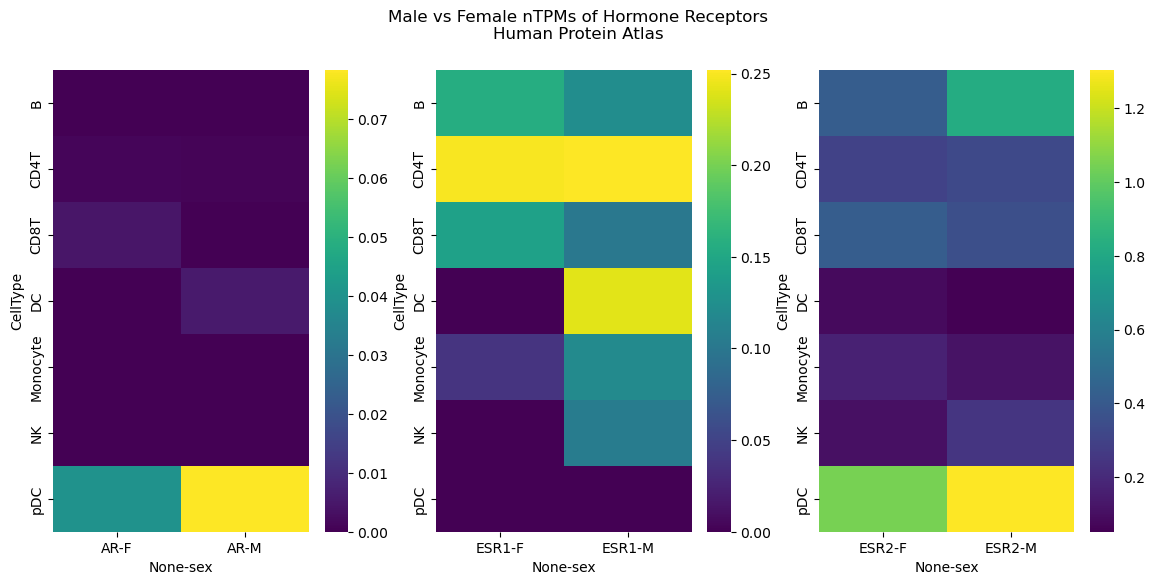

In [13]:
fig, ax = plt.subplots(1,3, figsize = (14,6))
sns.heatmap(heatmap_ar, cmap = 'viridis', ax = ax[0])
sns.heatmap(heatmap_esr1, cmap = 'viridis', ax = ax[1])
sns.heatmap(heatmap_esr2, cmap = 'viridis', ax = ax[2])

plt.suptitle('Male vs Female nTPMs of Hormone Receptors\nHuman Protein Atlas')

#plt.savefig('figures/humanprotatlas_maleVsFemaleHormoneReceptors_divided_nTPM.pdf', bbox_inches = 'tight', dpi = 200)